<!-- Notebook Header Start -->

<h1 align="center">Spike Sorting</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-10-30<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Group  || Neuromechatronics Lab
</p>

---

## 📜 Project Overview

(to populate) 

- **Objective:** (to populate)
- **Scope:** (to populate)
- **Libraries:** `Python`, `Pandas`, `SciPy`

---

## 📊 Notebook Outline

1. **Data Import & Preprocessing**


---

## 📚 References & Additional Resources

- [Github: Kilosort4](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# Libraries

In [1]:
# Imports
from pathlib import Path
from tqdm import tqdm
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
import sys
# sys.path.insert(1, '../automations')
from automations import RM1

from probeinterface import write_prb
# Download channel maps for default probes
from kilosort.utils import download_probes
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import Probe, get_probe, generate_linear_probe

from spikeinterface.extractors import read_intan

from kilosort import run_kilosort
from kilosort import io

# File Definitions

In [2]:
# Parameters
RAT_NAME = 'DW322'
STIMULATION = 'DRGS_2_240918_130024'
DATA_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)
PROBE_DIRECTORY = Path(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322\A1x32-Edge-5mm-20-177-A32.prb')

# Data Import

### defining filepath for data

In [26]:
# NOTE: You will need to select the appropriate data stream. If you run without
#       specifying `stream_id`, you will get an error message explaining what
#       each stream corresponds to.
filepath = Path(f"D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project\{RAT_NAME}\{RAT_NAME}\{STIMULATION}\{STIMULATION}.rhd")
recording = read_intan(filepath, stream_id='0')
recording

IntanRecordingExtractor: 34 channels - 30.0kHz - 1 segments - 7,750,400 samples 
                         258.35s (4.31 minutes) - uint16 dtype - 502.61 MiB
  file_path: D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project\DW322\DW322\DRGS_2_240918_130024\DRGS_2_240918_130024.rhd

no probe information is given with this data, so we will need to define it or assign one from the probe interface library.

I will first show how to create the binary file using `Spike Interface` and numpy's `memmap()`

In [27]:
recording

IntanRecordingExtractor: 34 channels - 30.0kHz - 1 segments - 7,750,400 samples 
                         258.35s (4.31 minutes) - uint16 dtype - 502.61 MiB
  file_path: D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project\DW322\DW322\DRGS_2_240918_130024\DRGS_2_240918_130024.rhd

In [28]:
recording.get_channel_ids()

array(['A-000', 'A-001', 'A-002', 'A-003', 'A-004', 'A-005', 'A-006',
       'A-007', 'A-008', 'A-009', 'A-010', 'A-011', 'A-012', 'A-013',
       'A-014', 'A-015', 'A-016', 'A-017', 'A-018', 'A-019', 'A-020',
       'A-021', 'A-022', 'A-023', 'A-024', 'A-025', 'A-026', 'A-027',
       'A-028', 'A-029', 'A-030', 'A-031', 'B-000', 'B-001'], dtype='<U64')

In [29]:
# Get the list of all channel IDs
channel_ids = recording.get_channel_ids()

# Identify channels that start with 'B'
channels_to_remove = [ch for ch in channel_ids if ch.startswith('B')]

# Remove those channels from the recording
recording = recording.remove_channels(["B-000", "B-001"])

# Verify the channels have been removed
print(recording)

ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 7,750,400 samples 
                       258.35s (4.31 minutes) - uint16 dtype - 473.05 MiB


In [31]:
recording.get_channel_ids()

array(['A-000', 'A-001', 'A-002', 'A-003', 'A-004', 'A-005', 'A-006',
       'A-007', 'A-008', 'A-009', 'A-010', 'A-011', 'A-012', 'A-013',
       'A-014', 'A-015', 'A-016', 'A-017', 'A-018', 'A-019', 'A-020',
       'A-021', 'A-022', 'A-023', 'A-024', 'A-025', 'A-026', 'A-027',
       'A-028', 'A-029', 'A-030', 'A-031'], dtype='<U64')

## Import data and probe using `SpikeInterface`

In [33]:
# NOTE: Data will be saved as np.int16 by default since that is the standard
#       for ephys data. If you need a different data type for whatever reason
#       such as `np.uint16`, be sure to update this.
dtype = np.int16
filename, N, c, s, fs, probe_path = io.spikeinterface_to_binary(
    recording, DATA_DIRECTORY, data_name=f'{RAT_NAME}_{STIMULATION}_data.bin', dtype=dtype,
    chunksize=60000, export_probe=False, probe_name='probe.prb'
    )

kilosort.io : ========================================
kilosort.io : Loading recording with SpikeInterface...
kilosort.io : number of samples: 7750400
kilosort.io : number of channels: 32
kilosort.io : numbef of segments: 1
kilosort.io : sampling rate: 30000.0
kilosort.io : dtype: uint16
kilosort.io : ========================================
kilosort.io : Converting 130 data chunks with a chunksize of 60000 samples...
kilosort.io : 130 of 130 chunks converted...
kilosort.io : Data conversion finished.
kilosort.io : ========================================


this code will complete, but because there is no probe associated with the data, I will need to define one later on

## Import data and probe using `Numpy memmap`

### defining ouput file and loading data into binary in chunks:

In [6]:
# Define output binary file
output_file = DATA_DIRECTORY / f'{RAT_NAME}_{STIMULATION}_data_memmap.bin'

# Get data shape
num_channels = recording.get_num_channels()
num_samples = recording.get_num_frames()

# Create a memory-mapped file without using `with`
data_dtype = np.int16  # This is typically the standard for electrophysiology data
memmap_file = np.memmap(output_file, dtype=data_dtype, mode='w+', shape=(num_samples, num_channels))

# Define the chunk size for processing (e.g., 60,000 samples at a time)
chunk_size = 60000

# Loop through the data and write to the binary file in chunks
for start_idx in range(0, num_samples, chunk_size):
    end_idx = min(start_idx + chunk_size, num_samples)
    
    # Extract data chunk from the RecordingExtractor
    data_chunk = recording.get_traces(start_frame=start_idx, end_frame=end_idx)
    
    # Write the chunk to the memory-mapped file
    memmap_file[start_idx:end_idx, :] = data_chunk.astype(data_dtype)

# Explicitly flush changes to disk
memmap_file.flush()

print(f"Data successfully saved to {output_file}")


Data successfully saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322\DW322_DRGS_2_240918_130024_data_memmap.bin


### exporting probe data

this will NOT run correctly, since there is no probe data

In [7]:

# # Get the probe from the recording (if available)
# probe = recording.get_probe()

# # Define the path to save the probe configuration
# probe_path = DATA_DIRECTORY / 'probe.prb'

# # Save the probe configuration
# write_prb(probe_path, probe)


# Defining or assigning a probe

## downloading standard probes

you can use the `ProbeInterface` repository to define a standard probe.

You can then pull a probe from the `ProbeInterface` library

In [8]:
manufacturer = 'neuronexus'
probe_name = 'A1x32-Poly3-10mm-50-177'

probe = get_probe(manufacturer, probe_name)
print(probe)

A1x32-Poly3-10mm-50-177 - neuronexus - 32ch - 1shanks


but, this is not the probe we are using. Instead, we are using a `A1x32-Edge-5mm-20-177-A32`

This is not in the library, so I will have to

## defining a probe

the following parameters came from this website:

[Neuronexus Penetrating Probe Catalog](https://19885756.fs1.hubspotusercontent-na1.net/hubfs/19885756/Penetrating_probe_catalog_V1.8.pdf#page=1.06&gsr=0)

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

In [9]:
channel_mapping = pd.read_excel("Adapter_pinout.xlsx",sheet_name="summary",header=2).iloc[:,[8,10,12,14]]
channel_mapping

,A1x32 Probe.1,A32->O32 Adapter.1,Intan Board,Intan Input.1
0,32,32,T13,19
1,31,30,T14,20
2,30,31,B13,28
3,29,28,T15,21
4,28,29,B14,27
5,27,27,B15,26
6,26,17,B11,30
7,25,26,T16,22
8,24,18,T11,17
9,23,24,T17,23


the channel indices shall be the `Intan.1` column

(<matplotlib.collections.PolyCollection at 0x19cad90cf70>, None)

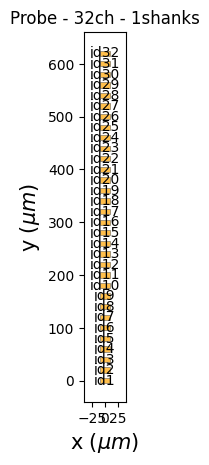

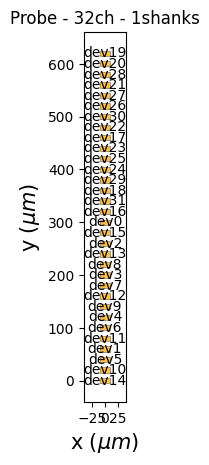

In [ ]:
linear_probe = generate_linear_probe(num_elec=32, ypitch=20)

# Define the number of channels and their positions along the probe shank
num_channels = 32
positions = [
    (0, i * 50) for i in range(num_channels)
]  # Channel spacing in micrometers

# Create a Probe object
linear_probe = Probe(ndim=2, si_units='um')
linear_probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 30})

# Assign electrical connections based on the connector diagram
linear_probe.set_contact_ids(np.arange(1, 33)) # I set the first input to 1, instead of Python's traditional 0, to match the connector diagram


linear_probe.set_device_channel_indices(channel_mapping['Intan Input.1'][::-1]) # the [::-1] is to reverse the order

# first plot: contact ids on the probe itself
plot_probe(linear_probe, with_device_index=False,with_contact_id=True)

# second plot: device ids on the probe; when the intan reads, say, "dev14", it means that it's the 1st input on the electrode probe (in graph 1)
plot_probe(linear_probe, with_device_index=True,with_contact_id=False)


In [11]:
linear_probe.to_dataframe()

,x,y,contact_shapes,width,height,shank_ids,contact_ids
0,0.0,0.0,rect,18.0,10.0,,1
1,0.0,20.0,rect,18.0,10.0,,2
2,0.0,40.0,rect,18.0,10.0,,3
3,0.0,60.0,rect,18.0,10.0,,4
4,0.0,80.0,rect,18.0,10.0,,5
5,0.0,100.0,rect,18.0,10.0,,6
6,0.0,120.0,rect,18.0,10.0,,7
7,0.0,140.0,rect,18.0,10.0,,8
8,0.0,160.0,rect,18.0,10.0,,9
9,0.0,180.0,rect,18.0,10.0,,10


### saving the probe - SpikeInterface Style

here, you'll use the `write_probeinterface` method:

In [12]:
from probeinterface import write_probeinterface

# Assuming 'linear_probe' is your defined Probe object
output_path = os.path.join(DATA_DIRECTORY, "A1x32-Edge-5mm-20-177-A32.json")  # Specify your output JSON file path"A1x32-Edge-5mm-20-177-A32.json" 
write_probeinterface(output_path, linear_probe)


### saving the probe - Kilosort 4 Style

to be able to use with Kilosort, you'll need to export the probe as a prb file using `write_prb`

In [13]:
from probeinterface import ProbeGroup, write_prb
# Multiple probes can be added to a ProbeGroup. We only have one, but a
# ProbeGroup wrapper is still necessary for `write_prb` to work.
pg = ProbeGroup()
pg.add_probe(linear_probe)
# CHANGE THIS PATH to wherever you want to save your probe file.
write_prb('A1x32-Edge-5mm-20-177-A32.prb', pg)

# defining the spike neuro probe:

In [ ]:
channel_mapping = pd.read_excel("Adapter_pinout.xlsx",sheet_name="summary",header=2).iloc[:,[8,10,12,14]]

linear_probe = generate_linear_probe(num_elec=32, ypitch=20)

# Define the number of channels and their positions along the probe shank
num_channels = 32
positions = [
    (0, i * 50) for i in range(num_channels)
]  # Channel spacing in micrometers

# Create a Probe object
linear_probe = Probe(ndim=2, si_units='um')
linear_probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 15})

# Assign electrical connections based on the connector diagram
linear_probe.set_contact_ids(np.arange(1, 33)) # I set the first input to 1, instead of Python's traditional 0, to match the connector diagram


linear_probe.set_device_channel_indices(channel_mapping['Intan Input.1'][::-1]) # the [::-1] is to reverse the order

# first plot: contact ids on the probe itself
plot_probe(linear_probe, with_device_index=False,with_contact_id=True)

# second plot: device ids on the probe; when the intan reads, say, "dev14", it means that it's the 1st input on the electrode probe (in graph 1)
plot_probe(linear_probe, with_device_index=True,with_contact_id=False)


from probeinterface import write_probeinterface

DATA_DIRECTORY = r"D:\Data\CMU.80 Data\88 Analyzed Data\88.009 SpikeNeuro-Linear-32"

# Assuming 'linear_probe' is your defined Probe object
output_path = os.path.join(DATA_DIRECTORY, "SpikeNeuro-Linear-32.json")  # Specify your output JSON file path"A1x32-Edge-5mm-20-177-A32.json" 
write_probeinterface(output_path, linear_probe)


from probeinterface import ProbeGroup, write_prb
# Multiple probes can be added to a ProbeGroup. We only have one, but a
# ProbeGroup wrapper is still necessary for `write_prb` to work.
pg = ProbeGroup()
pg.add_probe(linear_probe)
# CHANGE THIS PATH to wherever you want to save your probe file.
write_prb('SpikeNeuro-Linear-32.prb', pg)



# Running Kilosort4

At this point, it's a good idea to open the Kilosort gui and check that the
data and probe appear to have been loaded correctly and no settings need to be
tweaked. You will need to input the path to the binary datafile, the folder where
results should be saved, and select a probe file.

```conda activate kilosort```

```python -m kilosort```

From there, you can either launch Kilosort using the GUI or run the
next notebook cell to run it through the API.

In [14]:

from kilosort import run_kilosort, DEFAULT_SETTINGS

settings = DEFAULT_SETTINGS


# NOTE: 'n_chan_bin' is a required setting, and should reflect the total number
#       of channels in the binary file. For information on other available
#       settings, see `kilosort.run_kilosort.default_settings`.
settings = {'data_dir': DATA_DIRECTORY, 'n_chan_bin': 32}

ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = \
    run_kilosort(
        settings=settings, probe_name=PROBE_DIRECTORY,
        # save_preprocessed_copy=True
        )

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322\DW322_DRGS_2_240918_130024_data_memmap.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N 

In [15]:
# outputs saved to results_dir
results_dir = Path(settings['data_dir']).joinpath('kilosort4')
ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops['dshift']

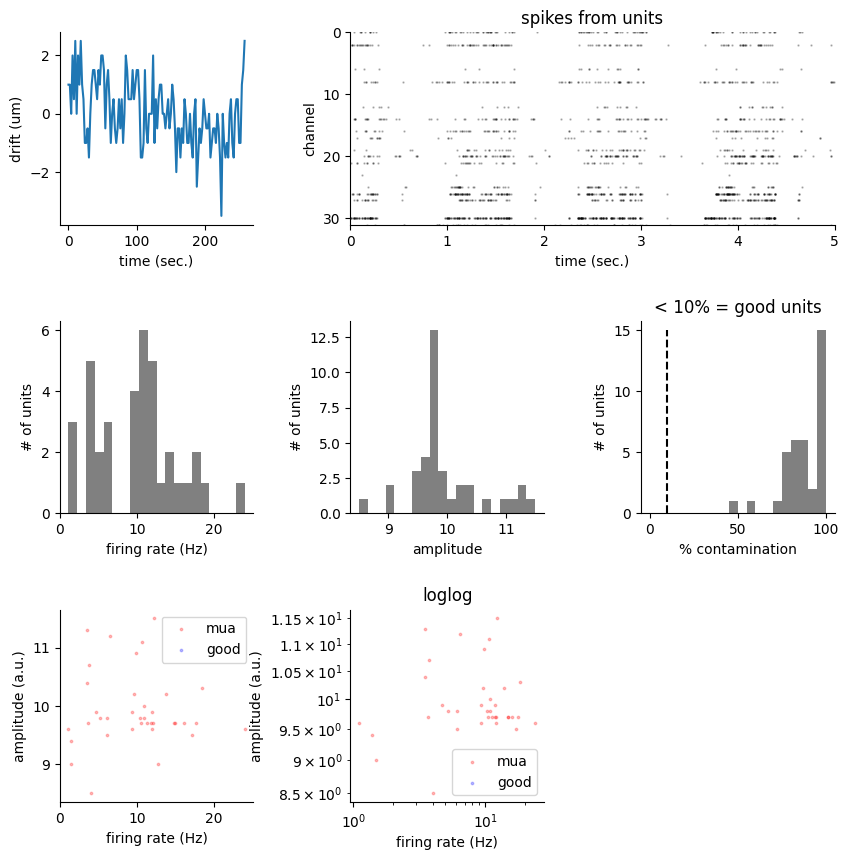

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*5)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

In [17]:
probe = ops['probe']
# x and y position of probe sites
xc, yc = probe['xc'], probe['yc']
nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ['good', 'mua']
for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j==0 else mua_units 
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()  
        cb = chan_best[wi]
        nsp = (clu==wi).sum()
        
        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


ValueError: high <= 0

<Figure size 1800x450 with 0 Axes>